## Test PSF measurement in the stack

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [5]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21)

Compare `psfex` and `pca` PSFs.

(238.39, 263.5)
(41, 41) (41, 41)
1.00000052618
(232.89, 251.15)
(41, 41) (31, 31)
1.0


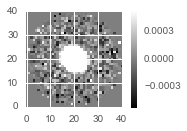

In [9]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
print res.psf.getAveragePosition()
psf = dit.afwPsfToArray(res.psf, testObj.im2.asAfwExposure()) #res.psf.computeImage()
print testObj.im2.psf.shape, psf.shape
print psf.sum()

res2 = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
print res2.psf.getAveragePosition()
psf2 = dit.afwPsfToArray(res2.psf, testObj.im2.asAfwExposure()) #res2.psf.computeImage()
print testObj.im2.psf.shape, psf2.shape
print psf2.sum()

#dit.plotImageGrid((res.psf.computeImage().getArray(),)) #, clim=(-0.001,0.001))
dit.plotImageGrid((psf,))

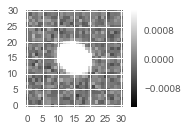

In [10]:
dit.plotImageGrid((psf2,)) #, clim=(-0.001,0.001))

In [11]:
print dit.computeMoments(testObj.im2.psf)
print dit.computeMoments(psf)
print dit.computeMoments(psf2)

(20.0, 20.000000000000004)
(19.985497897161974, 20.069583975358327)
(15.00287293657559, 15.050168935680972)


See how it works on a crowded field.

In [12]:
reload(dit)
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=500, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [13]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

(41, 41) (41, 41)
0.999999893236
0.999999893236
1.0
(20, 20)
(20, 20)
0.0145274494079


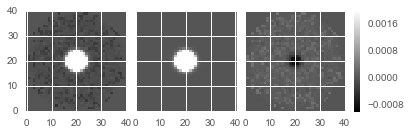

In [18]:
reload(dit)
psf1 = dit.afwPsfToArray(res.psf, testObj2.im1.asAfwExposure()) #res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.shape
print psf1.sum()

psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
psf1anorm = psf1a[np.abs(psf1a)>1e-3].sum()
print psf1a.sum()
psf1a /= psf1anorm

actualPsf1 = dit.makePsf(21, [1.6, 1.6], theta=0.)
print actualPsf1.sum()

print np.unravel_index(np.argmax(psf1a), psf1a.shape)
print np.unravel_index(np.argmax(actualPsf1), actualPsf1.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf1a - actualPsf1)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf1a, actualPsf1, actualPsf1 - psf1a), clim=(-0.001,0.002))

In [19]:
reload(dit)
res2 = dit.measurePsf(testObj2.im2.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

In [22]:
print dit.computeMoments(testObj2.im1.psf)
print dit.computeMoments(testObj2.im2.psf)
print dit.computeMoments(dit.afwPsfToArray(res.psf, testObj2.im1.asAfwExposure()))
print dit.computeMoments(dit.afwPsfToArray(res2.psf, testObj2.im2.asAfwExposure()))

(20.0, 20.000000000000004)
(20.0, 20.000000000000004)
(20.081999263809635, 19.978344296871001)
(19.993779885765747, 19.996865817918323)


(41, 41) (41, 41)
1.00000056421 (19.993779885765747, 19.996865817918323)
1.15022750839 1.00000056421
0.869393712911
1.0
(20, 20)
(20, 20)
0.0184851030669


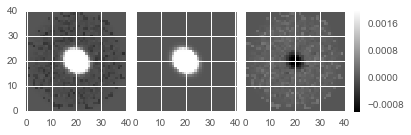

In [26]:
reload(dit)
psf2 = dit.afwPsfToArray(res2.psf, testObj2.im2.asAfwExposure())
print testObj2.im2.psf.shape, psf2.shape
print psf2.sum(), dit.computeMoments(psf2)

psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

actualPsf2 = dit.makePsf(21, [1.8, 2.2], theta=-45.)
print actualPsf2.sum()

print np.unravel_index(np.argmax(psf2a), psf2a.shape)
print np.unravel_index(np.argmax(actualPsf2), actualPsf2.shape)
print np.sqrt(((psf2a - actualPsf2)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf2a, actualPsf2, actualPsf2 - psf2a), clim=(-0.001,0.002))

In [31]:
reload(dit)

sh = dit.afwPsfToShape(res.psf, testObj2.im1.asAfwExposure())
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.afwPsfToShape(res2.psf, testObj2.im1.asAfwExposure())
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

1.59511927567 2.5453566643 2.54345620317 0.00195712450631
1.97217364332 3.97108199487 3.96281884202 -0.780198941657
1.59997320624 2.55991426068 2.55991426068 0.0
1.98996163727 4.03994623804 4.03994623804 -0.799989278877


 1.0 1.00000056421 1.32891249344
1.15022750839 1.00000056421
0.869393712911


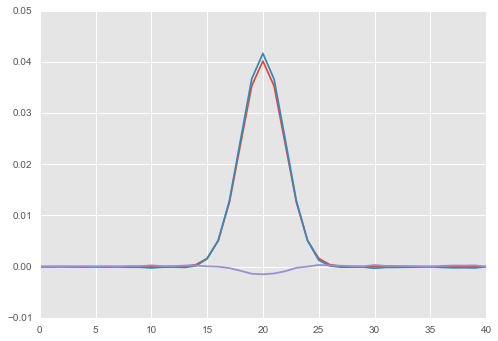

In [33]:
print np.abs(actualPsf2).sum(), psf2.sum(), np.abs(psf2).sum()
psf2a = psf2.copy()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

plt.plot((actualPsf2)[:,20])
plt.plot((psf2a)[:,20])
plt.plot((actualPsf2 - psf2a)[:,20])

### Last test - a really crowded field.

In [34]:
reload(dit)
testObj3 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [35]:
reload(dit)
res3 = dit.measurePsf(testObj3.im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')

(25, 25) (41, 41)
0.999999791551
0.999999791551
1.0
(20, 20)
(20, 20)
0.153260778631


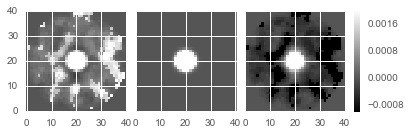

In [37]:
reload(dit)
psf3 = dit.afwPsfToArray(res3.psf, testObj3.im1.asAfwExposure())
print testObj3.im1.psf.shape, psf3.shape
print psf3.sum()

psf3a = psf3.copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>1e-3].sum()
print psf3a.sum()
psf3a /= psf3anorm

actualPsf3 = dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
print actualPsf3.sum()

print np.unravel_index(np.argmax(psf3a), psf3a.shape)
print np.unravel_index(np.argmax(actualPsf3), actualPsf3.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf3a - actualPsf3)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf3a, actualPsf3, actualPsf3 - psf3a), clim=(-0.001,0.002))

In [38]:
res3a = dit.measurePsf(testObj3.im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
actualPsf3a = dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)

In [39]:
sh = dit.afwPsfToShape(res3.psf, testObj3.im1.asAfwExposure())
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.afwPsfToShape(res3a.psf, testObj3.im2.asAfwExposure())
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

sh = dit.arrayToAfwPsf(actualPsf3).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.arrayToAfwPsf(actualPsf3a).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

1.59520802277 2.56830304299 2.52129388955 -0.00255246535545
2.16821505476 5.20725430192 4.44681860428 -1.02705532807
1.59997320624 2.55991426068 2.55991426068 0.0
1.98996163727 4.03994623804 4.03994623804 -0.799989278877


1.0 0.999999791551 1.00308591949
0.372597206384 0.869393712911
2.68386282671


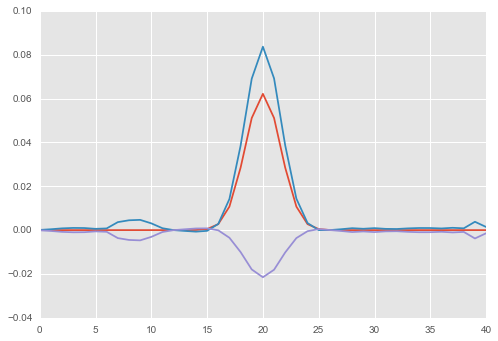

In [41]:
print np.abs(actualPsf3).sum(), psf3.sum(), np.abs(psf3).sum()
psf3a = psf3.copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>=1e-2].sum()
print psf3anorm, psf2a.sum()
psf3a /= psf3anorm
print psf3a.sum()

plt.plot((actualPsf3)[:,20])
plt.plot((psf3a)[:,20])
plt.plot((actualPsf3 - psf3a)[:,20])

In [42]:
xgrid, ygrid = np.meshgrid(np.arange(0, psf3a.shape[0]), np.arange(0, psf3a.shape[1]))
xmoment = np.average(xgrid, weights=psf3a)
ymoment = np.average(ygrid, weights=psf3a)
print xmoment, ymoment

reload(dit)
print dit.computeMoments(psf3a)
print dit.computeMoments(actualPsf3)

21.560784632 19.8696887435
(21.560784632026429, 19.869688743512256)
(20.0, 20.000000000000004)


In [53]:
def runTest(n_sources=500, seed=66):
    out = None
    try:
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), 
                             seed=seed, psfSize=21)
        
        try:
            im1 = testObj.im1.asAfwExposure()
            res1 = dit.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = dit.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            actualPsf1 = testObj.im1.psf #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.computeMoments(psf1)
        except:
            rms1 = shape1 = inputShape1 = None

        try:
            im2 = testObj.im2.asAfwExposure()
            res2 = dit.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = dit.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            actualPsf2 = testObj.im2.psf #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.computeMoments(psf2)
        except:
            rms2 = shape2 = inputShape2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed}
    except Exception as e:
        pass
    return out

In [ ]:
tmp = runTest(n_sources=50, seed=1);
#tmp

In [55]:
inputs = [(i, j) for i in np.arange(50, 5000, 100) for j in np.arange(1, 10)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)
import cPickle; import gzip
cPickle.dump(testResults1, gzip.GzipFile('27. psf measurement evaluation - part 2.p.gz', 'wb'))

450


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 32.0min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 87.5min
[Parallel(n_jobs=3)]: Done 450 out of 450 | elapsed: 110.6min finished


In [56]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults1[i] is not None])
tr = [t for t in testResults1 if t is not None]
print len(tr)
tr = {'nSources': ns,
      'rms1': np.array([t['rms1'] for t in tr])*100.,
      'rms2': np.array([t['rms2'] for t in tr])*100.,
      'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])}
tr = pd.DataFrame(tr)
sizeme(tr.head())

450


,nSources,rad1diff,rad2diff,rms1,rms2
0,50,0.001597,0.002068,0.016673,0.016148
1,50,0.000172,0.007544,0.019090,0.019691
2,50,0.003462,-0.003463,0.017893,0.021121
3,50,-0.000553,0.009086,0.015609,0.015349
4,50,0.001111,0.001056,0.015320,0.015708


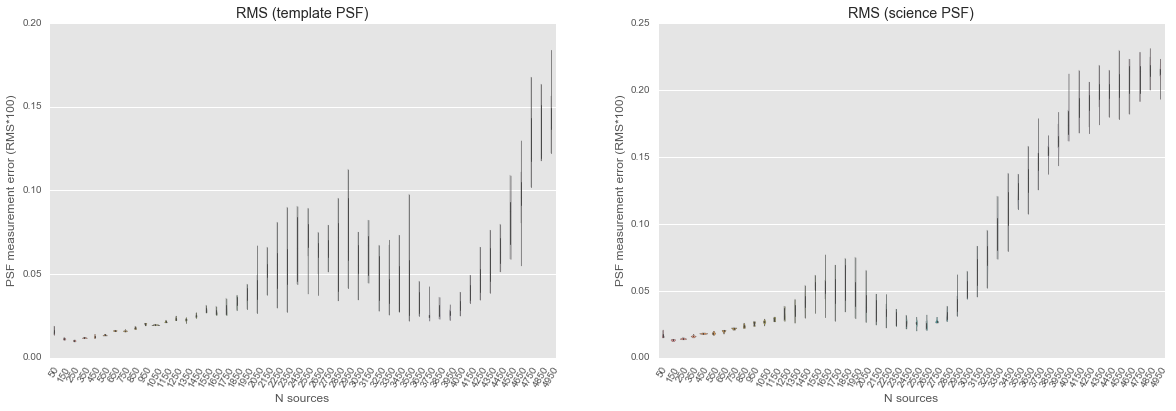

In [57]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS*100)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS*100)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

## Recall that ZOGY seems to break when RMS > 0.025.

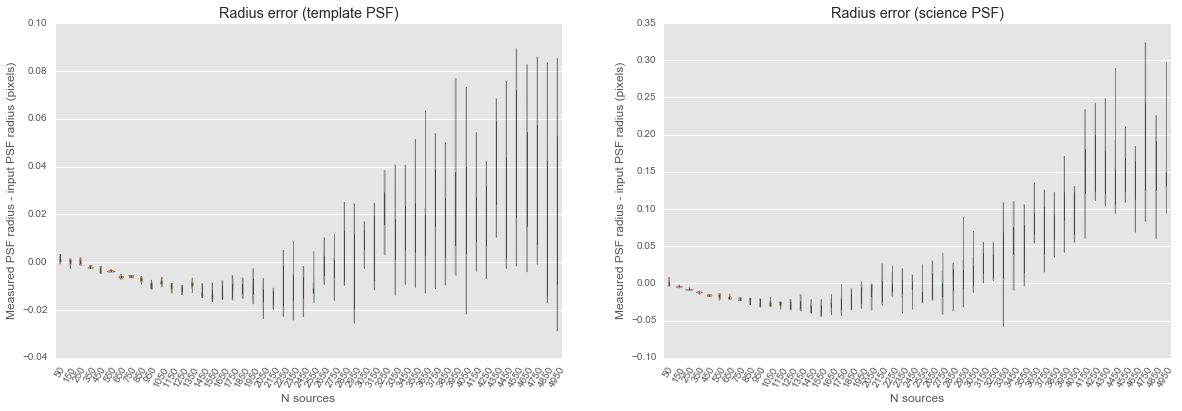

In [58]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rad1diff', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('Radius error (template PSF)')
g.set_ylabel('Measured PSF radius - input PSF radius (pixels)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rad2diff', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('Radius error (science PSF)')
g.set_ylabel('Measured PSF radius - input PSF radius (pixels)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

Let's update our RMS calculation to be weighted and renormalize the PSFs better (max of 1 rather than sum of 1).

In [60]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a**2.
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

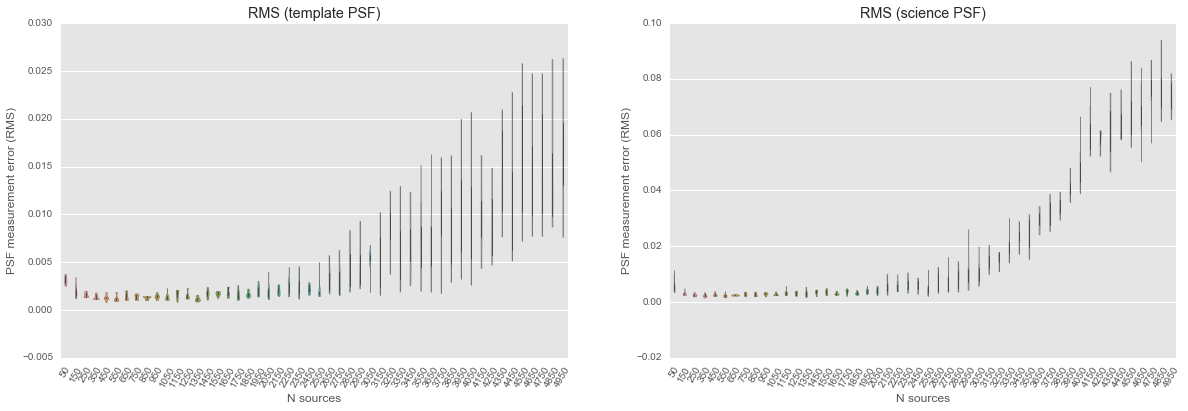

In [66]:
rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in testResults1]
rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in testResults1]
tr['rms1'] = np.array(rms1s)
tr['rms2'] = np.array(rms2s)

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);